In [54]:
from bs4 import BeautifulSoup as bs
import requests as rq
import pandas as pd
from pandas import read_html
import html5lib
import os
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from plotnine import *
import numpy as np

In [3]:
dic_beszámoló_adatok = {}
path = "/Users/markgyenes/Downloads/Prog_Projekt/ADAT"

for filenames in tqdm(os.listdir(path)):
    if ".html" in filenames or ".htm" in filenames:
        with open(os.path.join(path, filenames)) as file:
            soup = bs(file.read(), "html5lib")

            nyilvántartási_szám = soup.find_all("td", {"class": "Left ThirdWidth"})[
                0
            ].find_all("span", {"class": "FormData"})[0]
            azonosító = nyilvántartási_szám.text.strip()
            if azonosító in dic_beszámoló_adatok.keys():
                pass
            else:
                dic_beszámoló_adatok[azonosító] = {}

            vállalat_neve = soup.find_all("td", {"class": "Left FirmNameCell"})[
                0
            ].find_all("span", {"class": "FormData"})[0]
            név = vállalat_neve.text.strip()
            beszámoló_típusa = (
                soup.find_all("th", {"class": "TableHeaderFooter"})[0]
                .find_all("td", {"class": "Center FormData"})[0]
                .find_all("p")[2]
                .find_all("span")[1]
                .text.strip()
            )
            beszámoló_éve = (
                soup.find_all("th", {"class": "TableHeaderFooter"})[0]
                .find_all("td", {"class": "Center FormData"})[0]
                .find("p")
            )
            év = beszámoló_éve.text.strip()
            év = év[:4]
            előző_üzleti_év = str(int(év) - 1)
            dolgozók = (
                soup.find_all("table", {"class": "DataTable PrintBlock"})[0]
                .find_all("td", {"class": "Center FormData"})[0]
                .text.strip()
            )
            dolgozókk = (
                soup.find_all("table", {"class": "DataTable PrintBlock"})[0]
                .find_all("td", {"class": "Center FormData"})[1]
                .text.strip()
            )

            list_of_mérleg_sorok = (
                soup.find_all(
                    "table", {"class": "AttachmentTable repeat-header repeat-footer"}
                )[0]
                .find_all("tbody")[2]
                .find_all("tr")
            )
            dic_beszámoló_adatok[azonosító]["Vállalat_neve"] = név
            dic_beszámoló_adatok[azonosító]["Beszámoló típusa"] = beszámoló_típusa
            dic_beszámoló_adatok[azonosító][
                "Foglalkoztatottak_száma" + "_" + előző_üzleti_év
            ] = dolgozókk
            dic_beszámoló_adatok[azonosító][
                "Foglalkoztatottak_száma" + "_" + év
            ] = dolgozók

            for sorok in list_of_mérleg_sorok:
                sorok.find_all("td")
                if not sorok.find("td", {"class": "MainRow"}):
                    dic_beszámoló_adatok[azonosító][
                        sorok.find("span", {"class": "RowName"}).text.strip()
                        + "_"
                        + előző_üzleti_év
                    ] = (
                        sorok.find("td", {"class": "Right"})
                        .text.strip()
                        .replace("\xa0", "")
                    )
                    dic_beszámoló_adatok[azonosító][
                        sorok.find("span", {"class": "RowName"}).text.strip() + "_" + év
                    ] = (
                        sorok.find_all("td", {"class": "Right"})[2]
                        .text.strip()
                        .replace("\xa0", "")
                    )

            list_of_ERKI_sorok = (
                soup.find_all(
                    "table", {"class": "AttachmentTable repeat-header repeat-footer"}
                )[1]
                .find_all("tbody")[2]
                .find_all("tr")
            )
            for sorok in list_of_ERKI_sorok:
                sorok.find_all("td")
                if not sorok.find("td", {"class": "MainRow"}):
                    dic_beszámoló_adatok[azonosító][
                        sorok.find("span", {"class": "RowName"}).text.strip()
                        + "_"
                        + előző_üzleti_év
                    ] = (
                        sorok.find("td", {"class": "Right"})
                        .text.strip()
                        .replace("\xa0", "")
                    )
                    dic_beszámoló_adatok[azonosító][
                        sorok.find("span", {"class": "RowName"}).text.strip() + "_" + év
                    ] = (
                        sorok.find_all("td", {"class": "Right"})[2]
                        .text.strip()
                        .replace("\xa0", "")
                    )

    else:
        pass

In [4]:
df=pd.DataFrame(dic_beszámoló_adatok).T

In [5]:
df.isna().sum()

Vállalat_neve                                                                                    0
Beszámoló típusa                                                                                 0
Foglalkoztatottak_száma_2017                                                                     3
Foglalkoztatottak_száma_2018                                                                     5
Befektetett eszközök_2017                                                                        3
                                                                                              ... 
Adósságkonszolidálás miatt keletkező - eredményt csökkentő - konszolidációs különbözet_2015    194
Kapott osztalékok társult vállalkozástól_2015                                                  194
Kapott osztalékok egyéb részesedési viszonyban lévő vállalkozástól_2015                        194
Konszolidálásból adódó (számított) társasági adókülönbözet_2015                                194
Leányválla

In [6]:
oszlopok=list(df.columns)

In [7]:
df.isna().sum(axis=1).value_counts()

100    113
540     50
120      9
320      8
620      4
400      3
250      2
110      1
215      1
366      1
66       1
32       1
544      1
dtype: int64

# PANEL

## df_2015

In [8]:
# Olyan DataFramet csinálok, amiben csak az adott évre stimmelő sorok vannak benne
df_2015 = df.dropna(subset=["Foglalkoztatottak_száma_2015"])

# Csinálok egy olyan listát, amiben csak azok a változók vannak benne, amik az adott évhez tartoznak
oszlopok_2015 = ["azonosító", "Vállalat_neve", "Beszámoló típusa"]
for oszlop in oszlopok:
    if "2015" in oszlop:
        oszlopok_2015.append(oszlop)
    else:
        pass

# Kidobni az adatból azokat az oszlopokat, amik nem szerepelnek a listában
df_2015 = df_2015[df_2015.columns.intersection(oszlopok_2015)]

# Kiszedni az oszlopok nevéből a "_2015" stringet
df_2015.columns = df_2015.columns.str.replace("_2015", "")

# Év oszlopot beszúrni
df_2015.insert(0, "Év", "2015")

# df_2015
# 105 sor, tehát 105 vállalatnak van meg a 2016-os beszámolója és 178 változó van hozzá
# df_2015.isna().sum(axis=1).value_counts()

## df_2016

In [9]:
df_2016=df.dropna(subset=["Foglalkoztatottak_száma_2016"])
oszlopok_2016=["azonosító","Vállalat_neve","Beszámoló típusa"]
for oszlop in oszlopok:
    if "2016" in oszlop:
        oszlopok_2016.append(oszlop)
    else:
        pass
df_2016 = df_2016[df_2016.columns.intersection(oszlopok_2016)]
df_2016.columns = df_2016.columns.str.replace('_2016','')
df_2016.insert(0, 'Év', '2016')

# 105 rows × 178 columns
# df_2016.isna().sum(axis=1).value_counts()

## df_2017

In [10]:
df_2017=df.dropna(subset=["Foglalkoztatottak_száma_2017"])
oszlopok_2017=["azonosító","Vállalat_neve","Beszámoló típusa"]
for oszlop in oszlopok:
    if "2017" in oszlop:
        oszlopok_2017.append(oszlop)
    else:
        pass
df_2017 = df_2017[df_2017.columns.intersection(oszlopok_2017)]
df_2017.columns = df_2017.columns.str.replace('_2017','')
df_2017.insert(0, 'Év', '2017')

# 90 rows × 178 columns
# print(df_2017.isna().sum(axis=1).value_counts())

## df_2018

In [11]:
df_2018=df.dropna(subset=["Foglalkoztatottak_száma_2018"])
oszlopok_2018=["azonosító","Vállalat_neve","Beszámoló típusa"]
for oszlop in oszlopok:
    if "2018" in oszlop:
        oszlopok_2018.append(oszlop)
    else:
        pass
df_2018 = df_2018[df_2018.columns.intersection(oszlopok_2018)]
df_2018.columns = df_2018.columns.str.replace('_2018','')
df_2018.insert(0, 'Év', '2018')

# 90 rows × 178 columns
# print(df_2018.isna().sum(axis=1).value_counts())

## panel

In [12]:
frames = [df_2015, df_2016, df_2017, df_2018]
panel = pd.concat(frames)

# Egyszerűsített PANEL

In [13]:
egyszerű=panel.loc["01-09-060621"]
egyszerű=egyszerű.loc[:, ~egyszerű.isnull().all()]
új_oszlopok=list(egyszerű.columns)
picipanel = panel[panel.columns.intersection(új_oszlopok)]

# a forgalmiban nincs benne asszem az a 3 oszlop amit kibaszok még
picipanel=picipanel.drop("Aktivált saját teljesítmények értéke",1)
picipanel=picipanel.drop("Anyagjellegű ráfordítások",1)
picipanel=picipanel.drop("Személyi jellegű ráfordítások",1)
picipanel=picipanel.drop("Értékcsökkenési leírás",1)

picipanel.isna().sum()

Év                                       0
Vállalat_neve                            0
Beszámoló típusa                         0
Foglalkoztatottak_száma                  0
Befektetett eszközök                     0
Immateriális javak                       0
Tárgyi eszközök                          0
Befektetett pénzügyi eszközök            0
Forgóeszközök                            0
Készletek                                0
Követelések                              0
Értékpapírok                             0
Pénzeszközök                             0
Aktív időbeli elhatárolások              0
Eszközök (aktívák) összesen              0
Saját tőke                               0
Jegyzett tőke                            0
Jegyzett, de még be nem fizetett tőke    0
Tőketartalék                             0
Eredménytartalék                         0
Lekötött tartalék                        0
Értékelési tartalék                      0
Adózott eredmény                         0
Céltartalék

In [17]:
for i in picipanel.columns.drop(['Év','Vállalat_neve','Beszámoló típusa']):
    picipanel[i]=picipanel[i].astype(int)

In [14]:
picipanel.loc[
    :,
    [
        "Foglalkoztatottak_száma",
        "Befektetett eszközök",
        "Immateriális javak",
        "Tárgyi eszközök",
        "Befektetett pénzügyi eszközök",
        "Forgóeszközök",
        "Készletek",
        "Követelések",
        "Értékpapírok",
        "Pénzeszközök",
        "Aktív időbeli elhatárolások",
        "Eszközök (aktívák) összesen",
        "Saját tőke",
        "Jegyzett tőke",
        "Jegyzett, de még be nem fizetett tőke",
        "Tőketartalék",
        "Eredménytartalék",
        "Lekötött tartalék",
        "Értékelési tartalék",
        "Adózott eredmény",
        "Céltartalékok",
        "Kötelezettségek",
        "Hátrasorolt kötelezettségek",
        "Hosszú lejáratú kötelezettségek",
        "Rövid lejáratú kötelezettségek",
        "Passzív időbeli elhatárolások",
        "Források (passzívák) összesen",
        "Értékesítés nettó árbevétele",
        "Egyéb bevételek",
        "Egyéb ráfordítások",
        "Üzemi (üzleti) tevékenység eredménye",
        "Pénzügyi műveletek bevételei",
        "Pénzügyi műveletek ráfordításai",
        "Pénzügyi műveletek eredménye",
        "Adózás előtti eredmény",
        "Adófizetési kötelezettség",
    ],
] = picipanel.loc[
    :,
    [
        "Foglalkoztatottak_száma",
        "Befektetett eszközök",
        "Immateriális javak",
        "Tárgyi eszközök",
        "Befektetett pénzügyi eszközök",
        "Forgóeszközök",
        "Készletek",
        "Követelések",
        "Értékpapírok",
        "Pénzeszközök",
        "Aktív időbeli elhatárolások",
        "Eszközök (aktívák) összesen",
        "Saját tőke",
        "Jegyzett tőke",
        "Jegyzett, de még be nem fizetett tőke",
        "Tőketartalék",
        "Eredménytartalék",
        "Lekötött tartalék",
        "Értékelési tartalék",
        "Adózott eredmény",
        "Céltartalékok",
        "Kötelezettségek",
        "Hátrasorolt kötelezettségek",
        "Hosszú lejáratú kötelezettségek",
        "Rövid lejáratú kötelezettségek",
        "Passzív időbeli elhatárolások",
        "Források (passzívák) összesen",
        "Értékesítés nettó árbevétele",
        "Egyéb bevételek",
        "Egyéb ráfordítások",
        "Üzemi (üzleti) tevékenység eredménye",
        "Pénzügyi műveletek bevételei",
        "Pénzügyi műveletek ráfordításai",
        "Pénzügyi műveletek eredménye",
        "Adózás előtti eredmény",
        "Adófizetési kötelezettség",
    ],
].astype(
    int
)

# PICIPANEL VIZUALIZÁLÁSA

### Density (Adózott Eredmény)

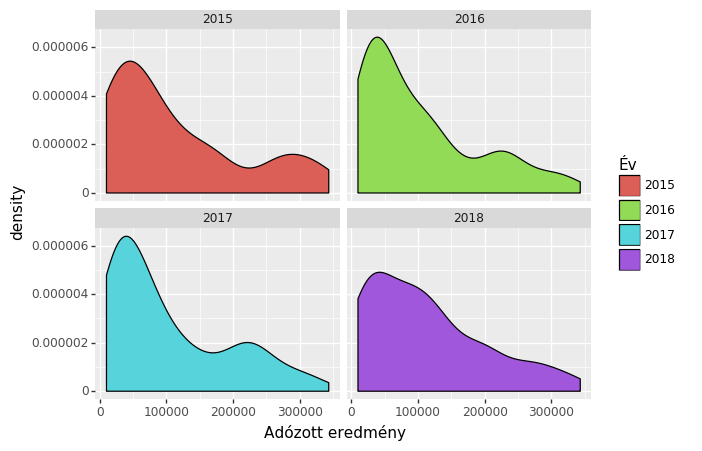

<ggplot: (7552293701)>

In [75]:
felso=np.quantile(picipanel['Adózott eredmény'],0.8)
also=np.quantile(picipanel['Adózott eredmény'],0.2)
ggplot(picipanel.loc[(picipanel["Adózott eredmény"] < felso)&(picipanel["Adózott eredmény"] > also),]) + aes(
    x="Adózott eredmény"
) +geom_density(aes(fill="Év")) + facet_wrap("Év")

### Histogram (Árbevétel)

/Applications/anaconda3/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 10'. Pick better value with 'binwidth'.


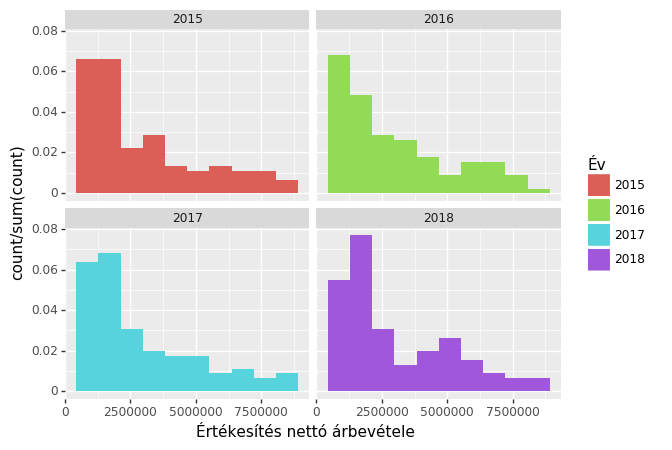

<ggplot: (7550168513)>

In [77]:
felso=np.quantile(picipanel['Értékesítés nettó árbevétele'],0.8)
also=np.quantile(picipanel['Értékesítés nettó árbevétele'],0.2)
ggplot(picipanel.loc[(picipanel["Értékesítés nettó árbevétele"] < felso)&(picipanel["Értékesítés nettó árbevétele"] > also),]) + aes(
    x="Értékesítés nettó árbevétele"
) + geom_histogram(aes(fill="Év",y="stat(count)/sum(stat(count))")) + facet_wrap("Év")

# 1 Vagyoni helyzet elemzése
### https://saldokiado.hu/assets/res/download/_vallalatertekeles-magyar-szamviteli-kornyezetben.pdf

## 1.1 Befektetett eszközök aránya

/Applications/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:369: PlotnineWarning: stat_density : Removed 1 rows containing non-finite values.


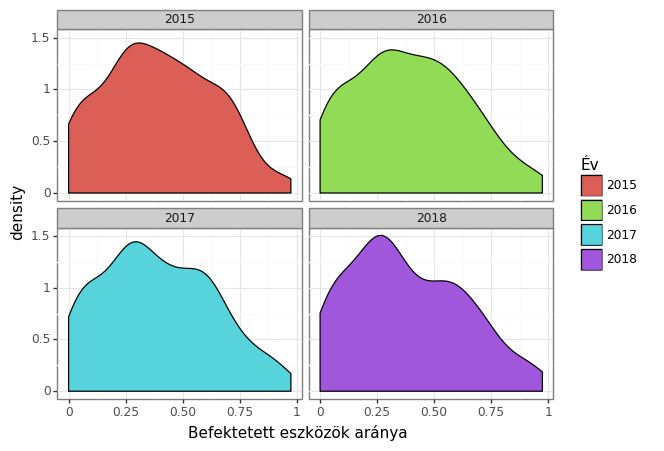

<ggplot: (7552732877)>

In [81]:
picipanel['Befektetett eszközök aránya']=picipanel['Befektetett eszközök']/picipanel['Eszközök (aktívák) összesen']
ggplot(picipanel)+aes(x="Befektetett eszközök aránya")+geom_density(aes(fill="Év"))+facet_wrap('Év')+theme_bw()

## 1.2 Befektetett eszközök belsõ szerkezete

### 1.2.1 Immateriális javak belső aránya

/Applications/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:369: PlotnineWarning: stat_density : Removed 1 rows containing non-finite values.


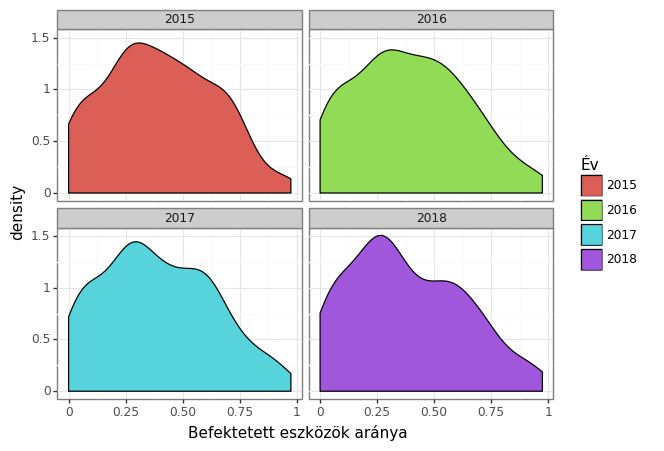

<ggplot: (7552560805)>

In [80]:
picipanel['Immateriális javak belső aránya']=picipanel['Immateriális javak']/picipanel['Befektetett eszközök']
ggplot(picipanel)+aes(x="Befektetett eszközök aránya")+geom_density(aes(fill="Év"))+facet_wrap('Év')+theme_bw()

### 1.2.2 Tárgyi Eszközök belső aránya

/Applications/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:369: PlotnineWarning: stat_density : Removed 9 rows containing non-finite values.


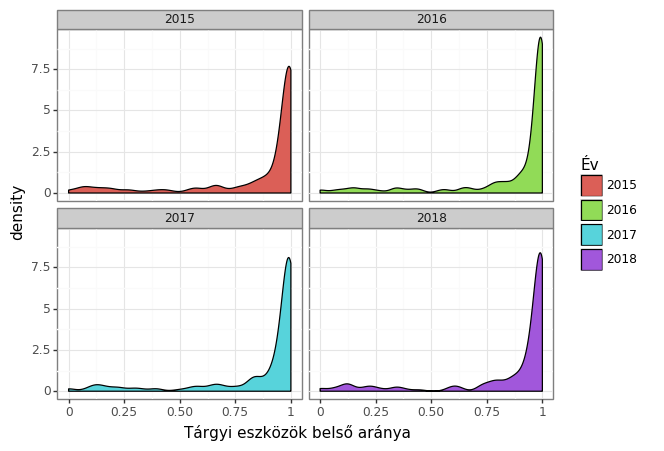

<ggplot: (7549808533)>

In [83]:
picipanel['Tárgyi eszközök belső aránya']=picipanel['Tárgyi eszközök']/picipanel['Befektetett eszközök']
ggplot(picipanel)+aes(x="Tárgyi eszközök belső aránya")+geom_density(aes(fill="Év"))+facet_wrap('Év')+theme_bw()

### 1.2.3 Befektetett pénzügyi eszközök belső aránya

/Applications/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:369: PlotnineWarning: stat_density : Removed 9 rows containing non-finite values.


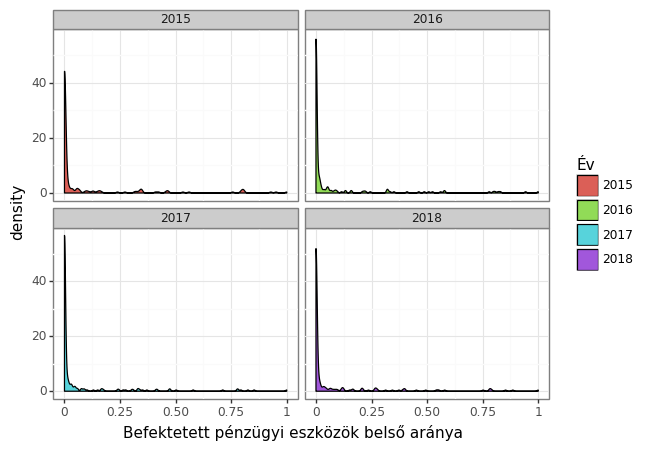

<ggplot: (7547835717)>

In [84]:
picipanel['Befektetett pénzügyi eszközök belső aránya']=picipanel['Befektetett pénzügyi eszközök']/picipanel['Befektetett eszközök']
ggplot(picipanel)+aes(x="Befektetett pénzügyi eszközök belső aránya")+geom_density(aes(fill="Év"))+facet_wrap('Év')+theme_bw()

# Foglalkoztatottak számának alakulása a különböző években

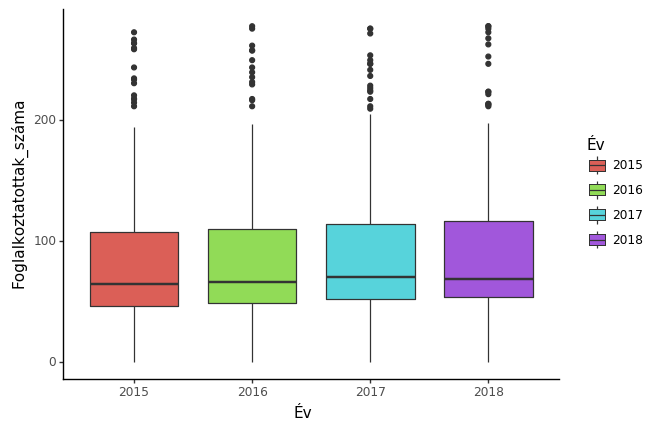

<ggplot: (7548536205)>

In [64]:
ggplot(
    picipanel.loc[
        picipanel["Foglalkoztatottak_száma"]
        < np.quantile(picipanel["Foglalkoztatottak_száma"], 0.90),
    ]
) + aes(x="Év", y="Foglalkoztatottak_száma") + geom_boxplot(aes(fill="Év")) + theme_classic()